# Libraries

In [1]:
import pandas as pd
import numpy as np
import os
from sentence_transformers import SentenceTransformer, util
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import string
import re
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer

pd.set_option("max_colwidth", 100)
pd.set_option("max_rows", 100) 
pd.set_option("precision", 2)

# Read

## Listings

In [2]:
listings_folder_path = '..\\data\\raw\\listings'

df_listings = pd.DataFrame()
for listing_file in os.listdir(listings_folder_path):
    listing_file_path = os.path.join(listings_folder_path,listing_file) 
    df = pd.read_csv(listing_file_path,compression='gzip')
    df_listings = pd.concat([df,df_listings])
    
df_listings['amenities'] = df_listings['amenities'].apply(lambda x: eval(x))

In [3]:
df_listings.loc[10848]

id                                                                                                                               729949246865083342
listing_url                                                                                         https://www.airbnb.com/rooms/729949246865083342
scrape_id                                                                                                                            20230903194229
last_scraped                                                                                                                             2023-09-04
source                                                                                                                                  city scrape
name                                                               Place to stay in Hacienda Heights · ★4.87 · 1 bedroom · 1 bed · 1.5 shared baths
description                                     Since our airbnb is in high demand, we are providing this listin

## Reviews

In [4]:
reviews_folder_path = '..\\data\\raw\\reviews'

df_reviews = pd.DataFrame()
for review_file in os.listdir(reviews_folder_path):
    review_file_path = os.path.join(reviews_folder_path,review_file) 
    df = pd.read_csv(review_file_path,compression='gzip')
    df_reviews = pd.concat([df,df_reviews])

# EDA

## Listings

### Summary Statistics

In [5]:
description = ["Airbnb's unique identifier for the listing",
'',
'Inside Airbnb "Scrape" this was part of',
'UTC. The date and time this listing was "scraped".',
'One of "neighbourhood search" or "previous scrape". "neighbourhood search" means that the listing was found by searching the city, while "previous scrape" means that the listing was seen in another scrape performed in the last 65 days, and the listing was confirmed to be still available on the Airbnb site.',
'Name of the listing',
'Detailed description of the listing',
"Host's description of the neighbourhood",
'URL to the Airbnb hosted regular sized image for the listing',
"Airbnb's unique identifier for the host/user",
'The Airbnb page for the host',
'Name of the host. Usually just the first name(s).',
'The date the host/user was created. For hosts that are Airbnb guests this could be the date they registered as a guest.',
"The host's self reported location",
'Description about the host',
'',
'',
'That rate at which a host accepts booking requests.',
'',
'',
'',
'',
'The number of listings the host has (per Airbnb calculations)',
'The number of listings the host has (per Airbnb calculations)',
'',
'',
'',
'',
'The neighbourhood as geocoded using the latitude and longitude against neighborhoods as defined by open or public digital shapefiles.',
'The neighbourhood group as geocoded using the latitude and longitude against neighborhoods as defined by open or public digital shapefiles.',
'Uses the World Geodetic System (WGS84) projection for latitude and longitude.',
'Uses the World Geodetic System (WGS84) projection for latitude and longitude.',
'Self selected property type. Hotels and Bed and Breakfasts are described as such by their hosts in this field',
"'[Entire home/apt|Private room|Shared room|Hotel]; All homes are grouped into the following three room types: Entire place, Private room, Shared room, Entire place",
'The maximum capacity of the listing',
'The number of bathrooms in the listing',
"The number of bathrooms in the listing. On the Airbnb web-site, the bathrooms field has evolved from a number to a textual description. For older scrapes, bathrooms is used.",
'The number of bedrooms',
'The number of bed(s)',
'',
'daily price in local currency',
'minimum number of night stay for the listing (calendar rules may be different)',
'maximum number of night stay for the listing (calendar rules may be different)',
'the smallest minimum_night value from the calender (looking 365 nights in the future)',
'the largest minimum_night value from the calender (looking 365 nights in the future)',
'the smallest maximum_night value from the calender (looking 365 nights in the future)',
'the largest maximum_night value from the calender (looking 365 nights in the future)',
'the average minimum_night value from the calender (looking 365 nights in the future)',
'the average maximum_night value from the calender (looking 365 nights in the future)',
'',
'[t=true; f=false]',
'avaliability_x. The availability of the listing x days in the future as determined by the calendar. Note a listing may not be available because it has been booked by a guest or blocked by the host.',
'avaliability_x. The availability of the listing x days in the future as determined by the calendar. Note a listing may not be available because it has been booked by a guest or blocked by the host.',
'avaliability_x. The availability of the listing x days in the future as determined by the calendar. Note a listing may not be available because it has been booked by a guest or blocked by the host.',
'avaliability_x. The availability of the listing x days in the future as determined by the calendar. Note a listing may not be available because it has been booked by a guest or blocked by the host.',
'',
'The number of reviews the listing has',
'The number of reviews the listing has (in the last 12 months)',
'The number of reviews the listing has (in the last 30 days)',
'The date of the first/oldest review',
'The date of the last/newest review',
'Overall experience. How was it?',
'Accuracy. Was it accurately represented with up-to-date photos and info?',
'Cleanliness. Did the place meet our standards?',
'Check-in. Should be easy.',
'Communication. Did the Host respond to messages promptly?',
'Location. Was the guest made aware of safety, transportation, points of interest, and special considerations like noise or other situations that might affect their stay?',
'Value. Was it worth the price?',
'The licence/permit/registration number',
'[t=true; f=false]. Whether the guest can automatically book the listing without the host requiring to accept their booking request. An indicator of a commercial listing.',
'The number of listings the host has in the current scrape, in the city/region geography.',
'The number of Entire home/apt listings the host has in the current scrape, in the city/region geography',
'The number of Private room listings the host has in the current scrape, in the city/region geography',
'The number of Shared room listings the host has in the current scrape, in the city/region geography',
'The number of reviews the listing has over the lifetime of the listing']


In [6]:
# General Info
non_null = df_listings.notnull().sum(axis=0)
dtype = df_listings.dtypes

general_info = pd.DataFrame(index=df_listings.columns)

for i, col in enumerate(general_info.index):
    general_info.loc[col,'Row 0'] = df_listings.loc[0, col]
    general_info.loc[col,'Not Null'] = non_null[col]
    general_info.loc[col,'Data Type'] = dtype[col]
    general_info.loc[col,'Description'] = description[i]
    
    if dtype[col] in ['int64','float64'] and 'id' not in col:
        general_info.loc[col,'Std'] = np.std(df_listings.loc[:,col])
        general_info.loc[col,'Mean'] = np.mean(df_listings.loc[:,col])
        general_info.loc[col,'25%'] = df_listings.loc[:,col].quantile(0.25)
        general_info.loc[col,'50%'] = df_listings.loc[:,col].quantile(0.5)
        general_info.loc[col,'75%'] = df_listings.loc[:,col].quantile(0.75)
        
general_info.style.background_gradient(
    cmap='Greens',subset=['Not Null']
).background_gradient(
    cmap='Greens',subset=['25%','50%','75%'],axis=1
).applymap(
    lambda x: 'color: transparent; background-color: transparent' if pd.isnull(x) else ''
)

ValueError: cannot set using a multi-index selection indexer with a different length than the value

### Most Frequent Neighbourhoods 

The neighbourhood as geocoded using the latitude and longitude against neighborhoods as defined by open or public digital shapefiles.

In [8]:
df_listings.groupby(['neighbourhood_group_cleansed','neighbourhood_cleansed'])[['id']].count().sort_values('id',ascending=False)[:10].style.background_gradient(cmap='Greens')

### Most Frequent Room Types

In [9]:
df_listings.groupby(['room_type'])[['id']].count().sort_values('id',ascending=False)[:10].style.background_gradient(cmap='Greens')

,id
room_type,
Entire home/apt,32863
Private room,10906
Shared room,755
Hotel room,70


### No. of People Accomodates

In [10]:
df_no_accomodates = df_listings.groupby(['accommodates'])[['id']].count().rename(columns={'id':'Properties'})
df_no_accomodates['Percentage'] = (df_no_accomodates['Properties']/df_no_accomodates['Properties'].sum())*100
df_no_accomodates['Cumulative Percentage'] = df_no_accomodates['Percentage'].cumsum()
df_no_accomodates.index.name = 'Accomodates'

df_no_accomodates.style.background_gradient(cmap='Greens')

,Properties,Percentage,Cumulative Percentage
Accomodates,,,
1,4546,10.19,10.19
2,15629,35.05,45.24
3,3469,7.78,53.02
4,7916,17.75,70.77
5,2212,4.96,75.73
6,4534,10.17,85.90
7,818,1.83,87.73
8,2608,5.85,93.58
9,297,0.67,94.25


In [11]:
## 50% of properties accomodate 3 or less people
## Even numbers are more frequent than odd; each room generally accomodates 2 people

### No. of Bedrooms

In [12]:
df_listings.groupby(['bedrooms'])[['id']].count().sort_values('id',ascending=False)[:10].style.background_gradient(cmap='Greens')

,id
bedrooms,
1.0,13872
2.0,8313
3.0,5008
4.0,2494
5.0,1008
6.0,334
7.0,124
8.0,40
9.0,20


### No. of Reviews

In [64]:
no_reviews = df_listings[['number_of_reviews']] 
no_reviews['bin'] = pd.qcut(no_reviews['number_of_reviews'],q=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],duplicates='drop')

no_reviews_group = no_reviews.groupby('bin').count().rename(columns={'number_of_reviews':'Properties'})
no_reviews_group['Percentage'] = (no_reviews_group['Properties']/no_reviews_group['Properties'].sum())*100
no_reviews_group['Cumulative Percentage'] = no_reviews_group['Percentage'].cumsum()
no_reviews_group.index.name = 'Review Intervals'

no_reviews_group.style.background_gradient(cmap='Greens').set_caption("Figure 1")

C:\Users\anton\AppData\Local\Temp\ipykernel_17360\1515493025.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_reviews['bin'] = pd.qcut(no_reviews['number_of_reviews'],q=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],duplicates='drop')


,Properties,Percentage,Cumulative Percentage
Review Intervals,,,
"(-0.001, 1.0]",15593,34.97,34.97
"(1.0, 2.0]",2506,5.62,40.59
"(2.0, 5.0]",4315,9.68,50.26
"(5.0, 11.0]",4592,10.30,60.56
"(11.0, 22.0]",4234,9.49,70.05
"(22.0, 45.0]",4493,10.08,80.13
"(45.0, 99.0]",4418,9.91,90.04
"(99.0, 2472.0]",4443,9.96,100.00


In [14]:
## 35% of properties have 0 or 1 reviews
## 30% of properties have over 10 reviews
## 10% of properties have over 100 reviews

### Most Common Amenities

In [15]:
def top_words(df,col,pd_slice,n=10):
    
    # Counter
    from collections import Counter

    # Dataframe slice
    df_sliced = df[pd_slice][col]
    
    # Flatten the lists in the Series
    flat_list = [word for sublist in df_sliced for word in sublist]

    # Use Counter to count the occurrences of each word
    word_counts = Counter(flat_list)

    # If you want the top N most common words, you can specify N
    top_n_words = word_counts.most_common(n)
    
    return top_n_words

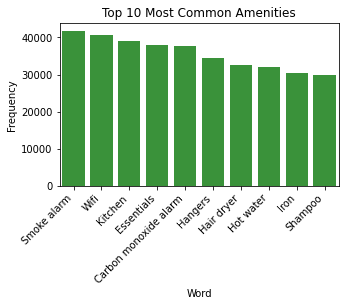

In [16]:
# Generate data
n = 10
most_common_words = top_words(df_listings,'amenities',df_listings['id']!=0,n=n)
most_common_df = pd.DataFrame(most_common_words,columns=['Word','Count'])

# Create a barplot
plt.figure(figsize=(5, 3))  # Adjust the figure size as needed

barplot = sns.barplot(x=most_common_df['Word'],y=most_common_df['Count'],color=sns.color_palette()[2])

# Rotate x-axis labels for better readability
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right')

# Set plot title and axis labels
plt.title(f'Top {n} Most Common Amenities')
plt.xlabel('Word')
plt.ylabel('Frequency')

# Show the plot
plt.show()

### Average Reviews per Category

In [17]:
df_listings[[
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value'
]].describe().style.background_gradient(cmap='Greens',axis=1)

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
count,32962.00,32731.00,32732.00,32724.00,32731.00,32723.00,32720.00
mean,4.71,4.77,4.71,4.84,4.83,4.78,4.67
std,0.62,0.48,0.51,0.42,0.45,0.42,0.51
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,4.69,4.75,4.67,4.85,4.85,4.74,4.60
50%,4.89,4.91,4.87,4.97,4.97,4.90,4.80
75%,5.00,5.00,5.00,5.00,5.00,5.00,4.95
max,5.00,5.00,5.00,5.00,5.00,5.00,5.00


### Review Distributions

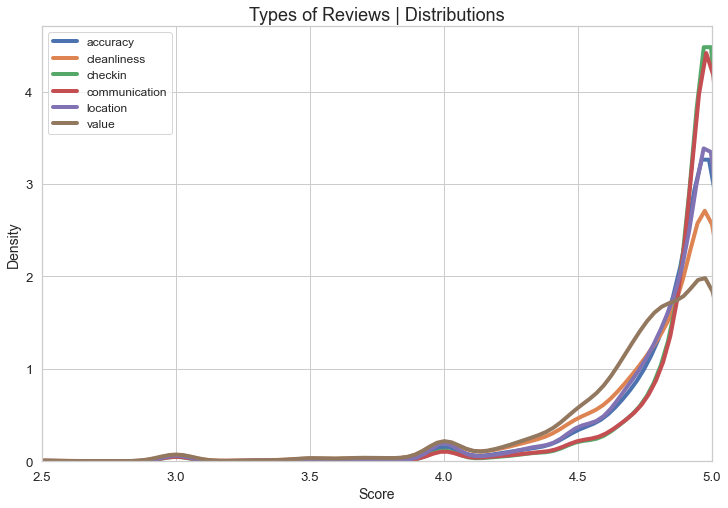

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axis
plt.figure(figsize=(12, 8))  # Adjusted figure size for better visibility
sns.set_theme(style="whitegrid", font_scale=1.2)  # Increased font size

# Loop through columns
for x in df_listings[['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                      'review_scores_communication', 'review_scores_location', 'review_scores_value']]:
    
    # Plot KDE for each dataset
    sns.kdeplot(df_listings[x], label=x.split('_')[-1], linewidth=4)

# Set plot title and axis labels with larger fonts
plt.title('Types of Reviews | Distributions', fontsize=18)
plt.xlabel('Score', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Add a legend with larger fonts
plt.legend(fontsize=12)

# Plot limits
plt.xlim((2.5, 5))

# Show the plot
plt.show()


In [19]:
## Check-Ins and Communication are the best review categories
## Value is the lowest review category
## Accuracy, Cleanliness and Location are in between

## Reviews

### Most Common Words

In [20]:
df_reviews_eda = df_reviews.copy()

# Merge reviews with the listing average review score
df_reviews_eda = pd.merge(
    left = df_reviews_eda,
    right = df_listings.rename(columns={'id':'listing_id'})[['listing_id','review_scores_rating']].drop_duplicates(),
    on = 'listing_id',
    how = 'left'
)

In [21]:
# Clean comments
nltk.download('stopwords') 
nltk.download('wordnet')

# Function to perform all cleaning steps
def clean_text(text):
        
    # Remove punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    
    # Lowercase the text
    text = text.lower()
    
    # Tokenization
    tokens = re.split(r'\W+', text)
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords]
    
    # Stemming
    tokens = [porter_stemmer.stem(word) for word in tokens]
    
    # Lemmatization
    tokens = [wordnet_lemmatizer.lemmatize(word) for word in tokens]

    return tokens

# Set of English stopwords
stopwords = set(nltk.corpus.stopwords.words('english'))

# Initialize stemmer and lemmatizer
porter_stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
df_reviews_eda['clean_comments'] = df_reviews_eda['comments'].fillna('').apply(clean_text)

In [23]:
def top_words(df,col,pd_slice,n=10):
    
    # Counter
    from collections import Counter

    # Dataframe slice
    df_sliced = df[pd_slice][col]
    
    # Flatten the lists in the Series
    flat_list = [word for sublist in df_sliced for word in sublist]

    # Use Counter to count the occurrences of each word
    word_counts = Counter(flat_list)

    # If you want the top N most common words, you can specify N
    top_n_words = word_counts.most_common(n)
    
    return top_n_words

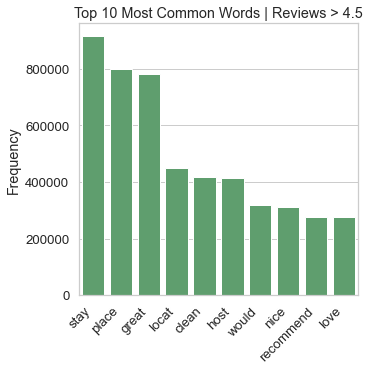

In [38]:
# Generate data
n = 10
most_common_words = top_words(df_reviews_eda,'clean_comments',df_reviews_eda['review_scores_rating']<=3,n=n)
most_common_df = pd.DataFrame(most_common_words,columns=['Word','Count'])

# Create a barplot
plt.figure(figsize=(5, 5))  # Adjust the figure size as needed

barplot = sns.barplot(x=most_common_df['Word'],y=most_common_df['Count'],color=sns.color_palette()[2])

# Rotate x-axis labels for better readability
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right')

# Set plot title and axis labels
plt.title(f'Top {n} Most Common Words of Reviews Below 3.0')
plt.xlabel('Word')
plt.ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.savefig('words_below.png')
plt.show()

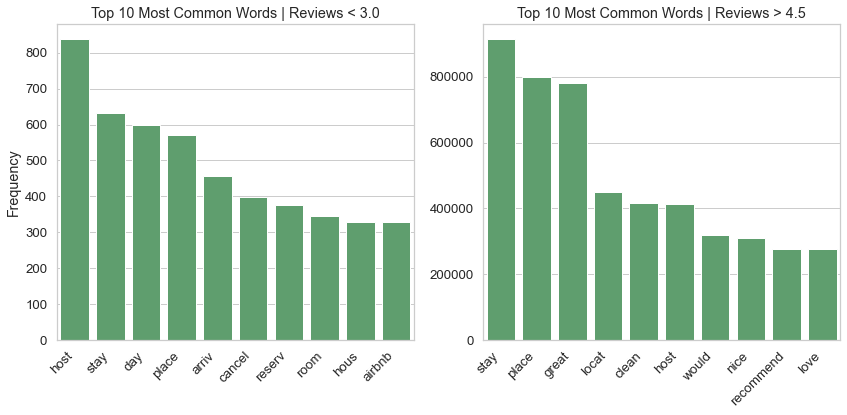

In [63]:
# Create a barplot
f, ax = plt.subplots(1, 2, figsize=(12, 6))  # Adjust the figure size as needed

# Generate data for reviews with rating <= 3.0
n = 10
most_common_words = top_words(df_reviews_eda, 'clean_comments', df_reviews_eda['review_scores_rating'] <= 3, n=n)
most_common_df = pd.DataFrame(most_common_words, columns=['Word', 'Count'])

barplot_1 = sns.barplot(x=most_common_df['Word'], y=most_common_df['Count'], color=sns.color_palette()[2], ax=ax[0])

# Generate data for reviews with rating >= 4.5
most_common_words = top_words(df_reviews_eda, 'clean_comments', df_reviews_eda['review_scores_rating'] >= 4.5, n=n)
most_common_df = pd.DataFrame(most_common_words, columns=['Word', 'Count'])

barplot_2 = sns.barplot(x=most_common_df['Word'], y=most_common_df['Count'], color=sns.color_palette()[2], ax=ax[1])

# Rotate x-axis labels for better readability
ax[0].set_xticklabels(barplot_1.get_xticklabels(), rotation=45, horizontalalignment='right')
ax[1].set_xticklabels(barplot_2.get_xticklabels(), rotation=45, horizontalalignment='right')

# Set plot title and axis labels
ax[0].set_title(f'Top {n} Most Common Words | Reviews < 3.0')
ax[0].set_xlabel('')
ax[0].set_ylabel('Frequency')

ax[1].set_title(f'Top {n} Most Common Words | Reviews > 4.5')
ax[1].set_xlabel('')
ax[1].set_ylabel('')

# Show the plot
plt.tight_layout()
plt.savefig('words.png')
plt.show()


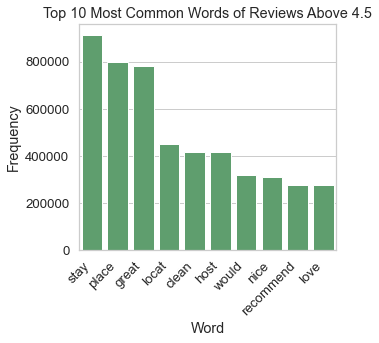

In [ ]:
# Generate data
n = 10
most_common_words = top_words(df_reviews_eda,'clean_comments',df_reviews_eda['review_scores_rating']>=4.5,n=n)
most_common_df = pd.DataFrame(most_common_words,columns=['Word','Count'])

# Create a barplot
plt.figure(figsize=(5, 5))  # Adjust the figure size as needed

barplot = sns.barplot(x=most_common_df['Word'],y=most_common_df['Count'],color=sns.color_palette()[2])

# Rotate x-axis labels for better readability
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right')

# Set plot title and axis labels
plt.title(f'Top {n} Most Common Words of Reviews Above 4.5')
plt.xlabel('Word')
plt.ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.savefig('words_above.png')
plt.show()

In [26]:
## Comparing most common words in reviews of properties with a overall review score under 3 and above 4.

## Properties with a score above 4.0 have 'stay','place', and 'great' as most common words, suggesting they had an overall great experience during their time at the property.
## Other common words include location, clean, and host, suggesting the Airbnb was clean and well localized with a nice host.

## On the other hand, properties with scores below 3.0 have 'host' as the most common word, well above second place. Other common words include arrival, reservation, and cancel.
## All of this suggests these users had bad experiences interacting with the host, and had reservation issues involving cancelations.